## Creating the RFM Propensity model


An RFM Propensity Model is a data-driven marketing analytics model that uses RFM (Recency, Frequency, and Monetary Value) analysis to predict and identify the likelihood of a customer making a future purchase or taking a specific action. RFM is a widely used customer segmentation technique that segments customers based on their historical behavior. Here's what each component of RFM represents:

> **Recency (R)**: Recency measures how recently a customer has made a purchase or engaged with a business. Customers who have made a purchase or interacted with the company more recently are considered more engaged and may have a higher propensity to make future purchases.

> **Frequency (F)**: Frequency quantifies how often a customer makes purchases or interacts with the business. Customers with a higher frequency of interactions are often more loyal and more likely to engage in the future.

> **Monetary Value (M)**: Monetary Value represents the total amount of money a customer has spent on purchases. Customers with higher monetary values are generally more valuable to the business and may be more likely to make larger purchases in the future.

In an RFM Propensity Model, machine learning techniques are often used to analyze historical customer data and generate predictive models. These models assign a propensity score or probability to each customer, indicating the likelihood that the customer will make a future purchase or take a specific action, such as subscribing to a service or responding to a marketing campaign.

The RFM Propensity Model can be a valuable tool for businesses in various ways:

> Targeted Marketing: It helps businesses target their marketing efforts more effectively by focusing on customers with a higher likelihood of converting or taking the desired action.

> Customer Segmentation: RFM scores can be used to segment customers into different groups, such as high-value, medium-value, and low-value customers. Each segment can receive tailored marketing strategies.

> Customer Retention: Identifying customers with a lower propensity to return allows businesses to implement retention strategies to keep them engaged and prevent churn.

> Resource Allocation: Businesses can allocate resources more efficiently by concentrating marketing budgets and efforts on customers with higher propensity scores.

> Personalization: RFM analysis can inform personalized product recommendations and content for customers, enhancing their overall experience.

In [1]:
# Importing the necessary Libraries
import pandas as pd
import numpy as np
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from datetime import timedelta

import warnings 
warnings.filterwarnings('ignore')

In [8]:
# Reading the data and changing the data type of the column "DateTime" from string to datetime format
cust = pd.read_csv('C:/Users/Omar Hamzic/Documents/Project_1_Customer_Propensity_Model/data/data/final_customer_data_cleaned.csv')
cust['DateTime'] = pd.to_datetime(cust['DateTime'])
cust(cust.shape)

TypeError: 'DataFrame' object is not callable

In [9]:
# we have to create the RFM model that we will use. 

def RFM_Features(df, customerID, invoiceDate, transID, sales):
    latest_date = df[invoiceDate].max() + timedelta(1) 

    RFMScores = df.groupby(customerID).agg({invoiceDate: lambda x: (latest_date - x.max()).days,
                                                                    transID: lambda x: len(x),
                                                                    sales: lambda x: sum(x)})
    RFMScores[invoiceDate] = RFMScores[invoiceDate].astype(int)
    RFMScores.rename(columns = {invoiceDate: 'Recency', 
                                transID: 'Frequency',
                                sales: 'Monetary'}, inplace =True)
    return RFMScores.reset_index()

In [10]:
RFM = RFM_Features(df =cust[cust['Action'] == 'purchase'], customerID = 'User_id', invoiceDate = "DateTime", transID= 'Session_id', sales = 'Total Price')
print(RFM.shape)
RFM.head()

(167, 4)


,User_id,Recency,Frequency,Monetary
0,5.144816e+10,10,2,21500.0
1,5.145551e+10,64,1,10000.0
2,5.146260e+10,7,2,550.0
3,5.146362e+10,40,2,950.0
4,5.146553e+10,10,2,15500.0


,Recency,Frequency,Monetary
count,167.000000,167.000000,167.000000
mean,112.263473,1.203593,11380.419162
std,91.085568,0.432685,20236.203462
min,1.000000,1.000000,150.000000
25%,41.500000,1.000000,1575.000000
50%,72.000000,1.000000,3000.000000
75%,164.000000,1.000000,10700.000000
max,345.000000,3.000000,160000.000000


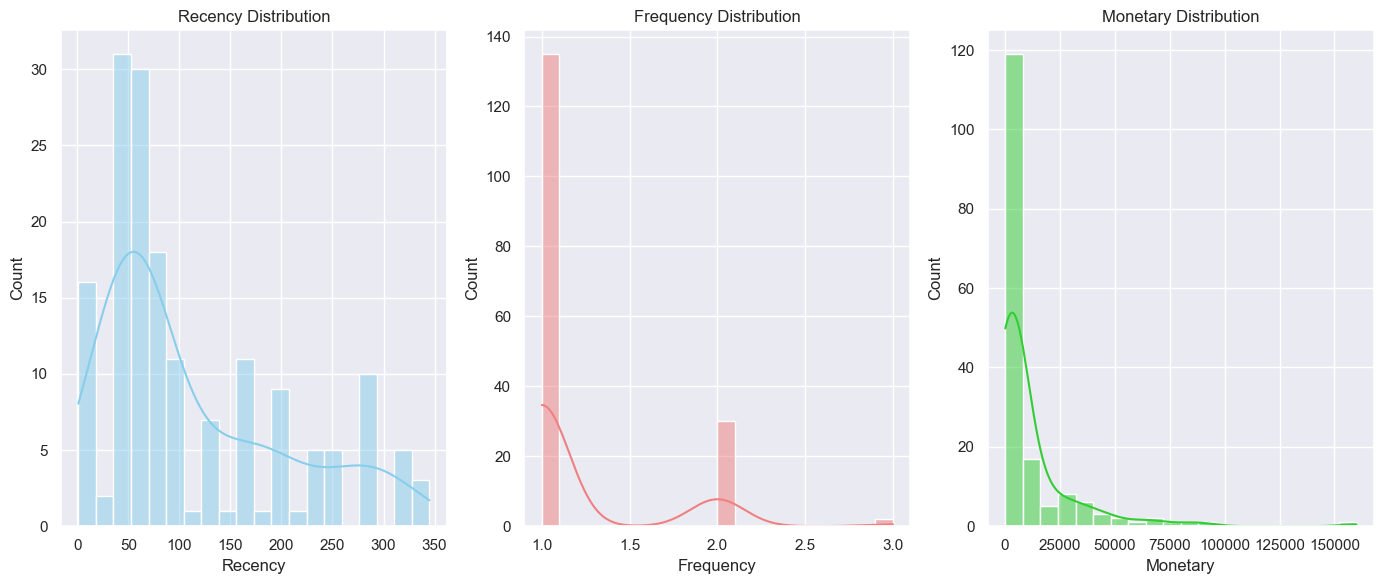

In [12]:
# Display summary statistics of the DataFrame
display(RFM.drop('User_id', axis=1).describe())

# Create subplots for the distribution plots
fig, ax = plt.subplots(1, 3, figsize=(14, 6))

# Create filled histograms using sns.histplot
sns.histplot(RFM['Recency'], bins=20, ax=ax[0], kde=True, color='skyblue')
sns.histplot(RFM['Frequency'], bins=20, ax=ax[1], kde=True, color='lightcoral')
sns.histplot(RFM['Monetary'], bins=20, ax=ax[2], kde=True, color='limegreen')

# Set titles for the subplots
ax[0].set_title("Recency Distribution", size=12)
ax[1].set_title("Frequency Distribution", size=12)
ax[2].set_title("Monetary Distribution", size=12)

# Display the subplots
plt.tight_layout()
plt.show()


In [13]:
RFM[['Recency', 'Frequency', 'Monetary']].quantile([0.25, 0.50, 0.75])
# Creating quantiles 
Quantiles = RFM[['Recency', 'Frequency', 'Monetary']].quantile([0.25, 0.50, 0.75])
Quantiles = Quantiles.to_dict()
Quantiles

{'Recency': {0.25: 41.5, 0.5: 72.0, 0.75: 164.0},
 'Frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 1.0},
 'Monetary': {0.25: 1575.0, 0.5: 3000.0, 0.75: 10700.0}}

In [25]:
#Creating RFM Rank
def RFMRanking(x, variable, quantile_dict):
    ''' Ranking the Recency, Frequency, and Monetary features based on quantile values '''

    # Define rank values
    rank_values = [4, 3, 2, 1]

    # Calculate the rank based on quantiles
    for i, q in enumerate([0.25, 0.5, 0.75]):
        if x <= quantile_dict[variable][q]:
            return rank_values[i]

    # If x is greater than the highest quantile, assign the lowest rank
    return rank_values[-1]


In [17]:
RFM['R'] = RFM['Recency'].apply(lambda x: RFMRanking(x, variable='Recency', quantile_dict=Quantiles))
RFM['F'] = RFM['Frequency'].apply(lambda x: RFMRanking(x, variable='Frequency', quantile_dict=Quantiles))
RFM['M'] = RFM['Monetary'].apply(lambda x: RFMRanking(x, variable='Monetary', quantile_dict=Quantiles))

In [19]:
RFM['Group'] = RFM['R'].apply(str) + RFM['F'].apply(str) + RFM['M'].apply(str)
RFM.head()

,User_id,Recency,Frequency,Monetary,R,F,M,Group
0,5.144816e+10,10,2,21500.0,4,4,4,444
1,5.145551e+10,64,1,10000.0,3,1,3,313
2,5.146260e+10,7,2,550.0,4,4,1,441
3,5.146362e+10,40,2,950.0,4,4,1,441
4,5.146553e+10,10,2,15500.0,4,4,4,444


In [20]:
# Check the number of score segments
RFM.Group.value_counts()

RFM["Score"] = RFM[['R', 'F', 'M']].sum(axis=1)
RFM.head()

,User_id,Recency,Frequency,Monetary,R,F,M,Group,Score
0,5.144816e+10,10,2,21500.0,4,4,4,444,12
1,5.145551e+10,64,1,10000.0,3,1,3,313,7
2,5.146260e+10,7,2,550.0,4,4,1,441,9
3,5.146362e+10,40,2,950.0,4,4,1,441,9
4,5.146553e+10,10,2,15500.0,4,4,4,444,12


In [21]:
# Loyalty levels
loyalty = ['Bronze', 'Silver', 'Gold', 'Platinum']
RFM['Loyalty_Level'] = pd.qcut(RFM['Score'], q=4, labels= loyalty)
RFM.head()

,User_id,Recency,Frequency,Monetary,R,F,M,Group,Score,Loyalty_Level
0,5.144816e+10,10,2,21500.0,4,4,4,444,12,Platinum
1,5.145551e+10,64,1,10000.0,3,1,3,313,7,Gold
2,5.146260e+10,7,2,550.0,4,4,1,441,9,Platinum
3,5.146362e+10,40,2,950.0,4,4,1,441,9,Platinum
4,5.146553e+10,10,2,15500.0,4,4,4,444,12,Platinum


In [22]:
rating = RFM.groupby('Loyalty_Level')[['Recency', 'Frequency', 'Monetary', 'Score']].mean()
rating

,Recency,Frequency,Monetary,Score
Loyalty_Level,,,,
Bronze,188.054545,1.000000,2436.363636,4.290909
Silver,102.813953,1.000000,7777.441860,6.000000
Gold,56.064516,1.032258,24183.870968,7.645161
Platinum,59.105263,1.868421,17957.894737,9.947368


In [23]:
cust_RFM = pd.merge(cust, RFM, on = 'User_id', how = 'left')
print(cust_RFM.shape)
cust_RFM.head()
cust_RFM.isna().sum()

(2090, 18)


User_id             0
Session_id          0
DateTime            0
Category            0
SubCategory         0
Action              0
Quantity         1889
Rate             1889
Total Price      1889
Recency           787
Frequency         787
Monetary          787
R                 787
F                 787
M                 787
Group             787
Score             787
Loyalty_Level     787
dtype: int64

In [24]:
cust_RFM.to_csv("C:/Users/Omar Hamzic/Documents/Project_1_Customer_Propensity_Model/data/data/final_customer_data_with_RFM.csv", index =False)